Alpha waves, oscillating between 8 and 12 Hz, represent a distinct rhythm within the human brain's electrical symphony. Prominent during relaxed wakefulness with closed eyes, they are closely linked to states of calmness, introspection, and heightened cognitive processing. Studies suggest alpha waves play a crucial role in attention, memory consolidation, and even creativity. Interestingly, individual alpha peak frequency varies, potentially influencing cognitive strengths and personality traits. While research is ongoing, understanding alpha waves offers valuable insights into brain function and potentially holds promise for applications in neurofeedback and cognitive enhancement.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D, MaxPooling2D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import scipy.signal as ss

## Import the Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/2023_ML_AI_projects

 BCI_Alpha_waves.txt			'CNN_Dogs&Cats.ipynb'
 Brain_Tumor_CNN.ipynb			'EEG Alpha Waves.ipynb'
 Brain_Tumors_Classification_CNN.ipynb


### This notebook will take you through how to analyse brain wave data. This data was collected in the Neural Engineering Laboratory at the University of Missouri - Columbia. Alpha waves on EEG are seen when eyes are closed while awake, but can be seen when eyes are open while awake.

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/2023_ML_AI_projects/BCI_Alpha_waves.txt",skiprows=6,header=None)

In [ ]:
df.columns=['index','channel1','channel2','channel3','channel4','acc1','acc2','acc3','time_std','timestamp']
df.drop(['index'],axis=1,inplace=True)

In [ ]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127157 entries, 0 to 127156
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       127157 non-null  int64  
 1   1       127157 non-null  float64
 2   2       127157 non-null  float64
 3   3       127157 non-null  float64
 4   4       127157 non-null  float64
 5   5       127157 non-null  float64
 6   6       127157 non-null  float64
 7   7       127157 non-null  float64
 8   8       127157 non-null  object 
 9   9       127157 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 9.7+ MB


The dataset comprises eight channels, each representing a continuous electroencephalogram (EEG) sample captured at 200 Hz (200 samples per second). This provides high-resolution insights into brain activity.

Four channels were positioned on the frontal lobe (forehead) and two on the temporal lobes (sides of the head), covering key regions associated with various cognitive functions. Additionally, three accelerometer channels (acc1-3) capture head movements to account for potential artifacts related to blinking or other actions.

Timestamps in the final two columns ensure precise temporal alignment of all data points.

It's important to note the potential presence of artifacts related to Bell's phenomenon, which occurs when eyes are closed and manifests as increased polarity in the leads. These artifacts necessitate filtering before subsequent analysis to ensure accurate interpretation of the EEG data.

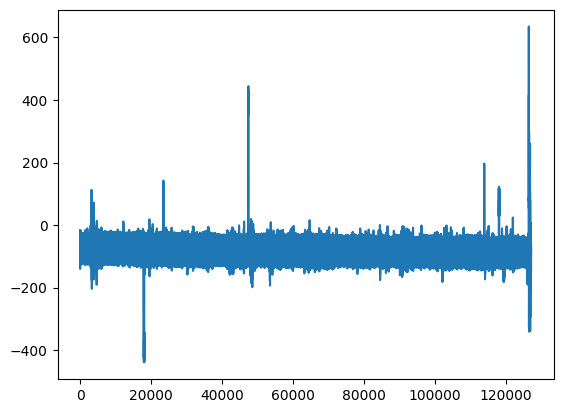

In [ ]:
plt.figure()
plt.plot(df['channel2'])

Remove drift;

The mean of the data changes over time. This is called drift. We can remove this trend in the data using scipy's detrend function.

> Indented block



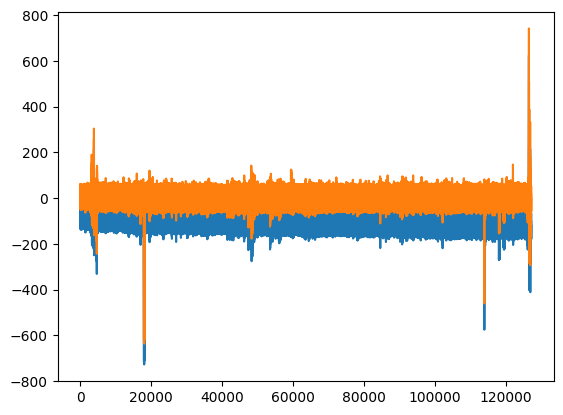

In [ ]:
plt.plot(df['channel1'])
plt.plot(ss.detrend(df['channel1']))

In [ ]:
df['channel1'] = ss.detrend(df['channel1'])
df['channel2'] = ss.detrend(df['channel2'])
df['channel3'] = ss.detrend(df['channel3'])
df['channel4'] = ss.detrend(df['channel4'])

Artifact removal;
Whenever the subject moved or blinked, there is a large deviation in the potential of all channels. We need to remove these.

In [ ]:
zchan1 = (df['channel1']-np.mean(df['channel1']))/np.std(df['channel1'])
zchan2 = (df['channel2']-np.mean(df['channel2']))/np.std(df['channel2'])
zchan3 = (df['channel3']-np.mean(df['channel3']))/np.std(df['channel3'])
zchan4 = (df['channel4']-np.mean(df['channel4']))/np.std(df['channel4'])

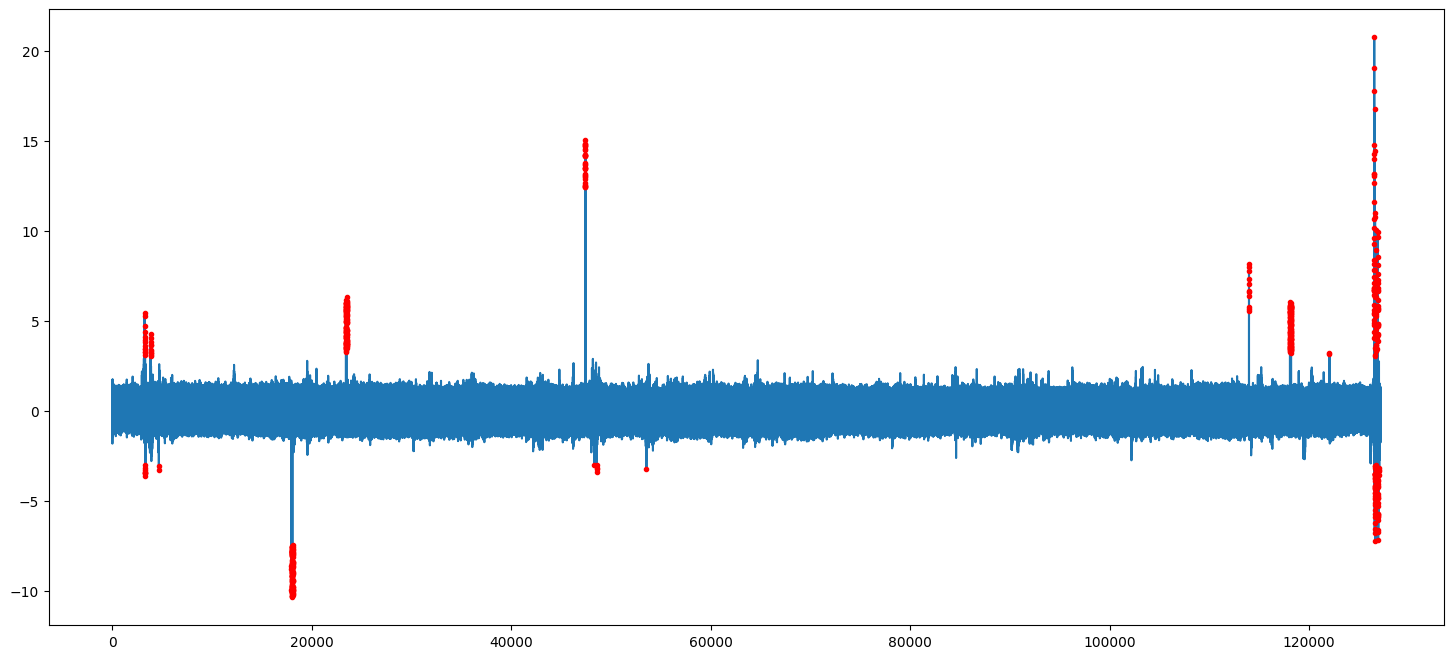

In [ ]:
plt.figure(figsize=(18,8))
plt.plot(zchan2)
plt.plot(zchan2[np.abs(zchan2)>3],'r.')

Make y labels;
The subject was in two states during the experiment; their eyes were either open or closed. Below, we define the times at which the eyes were open or closed.

In [ ]:
df['seconds_from_start']=(df['timestamp']-df['timestamp'].iloc[0])/1000

In [ ]:
y_labels = np.zeros((df['time_std'].shape[0],1))

In [ ]:
y_labels[(60<df.seconds_from_start)&(df.seconds_from_start<90)] = 1
y_labels[(120<df.seconds_from_start)&(df.seconds_from_start<150)] = 1
y_labels[(180<df.seconds_from_start)&(df.seconds_from_start<210)] = 1
y_labels[(240<df.seconds_from_start)&(df.seconds_from_start<270)] = 1
y_labels[(300<df.seconds_from_start)&(df.seconds_from_start<330)] = 1
y_labels[(360<df.seconds_from_start)&(df.seconds_from_start<390)] = 1
y_labels[(420<df.seconds_from_start)&(df.seconds_from_start<450)] = 1
y_labels[(480<df.seconds_from_start)&(df.seconds_from_start<510)] = 1
y_labels[(540<df.seconds_from_start)&(df.seconds_from_start<570)] = 1
y_labels[(600<df.seconds_from_start)&(df.seconds_from_start<630)] = 1

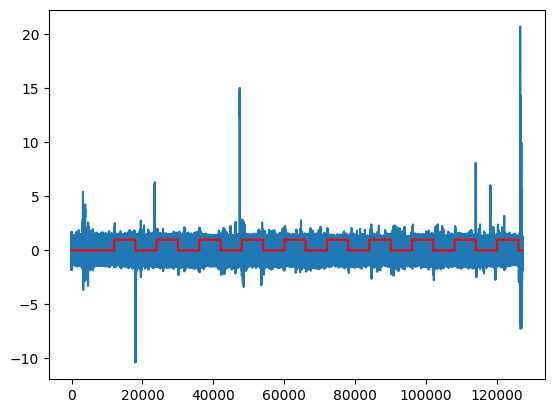

In [ ]:
plt.plot(zchan2)
plt.plot(y_labels,'r')

Look closely at the blue line above. It traces the activity of a single channel within your brain, captured during an EEG recording. The red line acts as a key, telling us whether your eyes were closed (blue = closed, red = open) at each point in time.

Before we dive deeper into the secrets this blue line holds, we need to do some housekeeping. Imagine pesky whispers trying to drown out a captivating conversation. Similarly, electrical noise from power lines (around 60 Hz) can interfere with the delicate signals recorded by EEG. To ensure clarity, we'll use a special filter to silence these whispers, allowing the true brain story to shine through.

In [ ]:
b, a = ss.iirnotch(60.0, 200.0, 200.)

zchan1 = ss.filtfilt(b,a,zchan1)
zchan2 = ss.filtfilt(b,a,zchan2)
zchan3 = ss.filtfilt(b,a,zchan3)
zchan4 = ss.filtfilt(b,a,zchan4)

zchan1[np.abs(zchan1)>3] = np.nan
zchan2[np.abs(zchan2)>3] = np.nan
zchan3[np.abs(zchan3)>3] = np.nan
zchan4[np.abs(zchan4)>3] = np.nan
y_labels[(np.abs(zchan1)>3) | (np.abs(zchan2)>3) | (np.abs(zchan3)>3) | (np.abs(zchan4)>3)] = np.nan

In [ ]:
df['channel1'] = zchan1
df['channel2'] = zchan2
df['channel3'] = zchan3
df['channel4'] = zchan4
df['y_labels'] = y_labels

The graph below shows the power spectral density (PSD) of EEG recordings in the eyes-closed and eyes-open conditions. The PSD is a measure of the power of different frequency bands in a signal. As expected, the eyes-closed condition shows a prominent peak in the alpha band (8-12 Hz), which is associated with relaxed wakefulness. The eyes-open condition shows a decrease in power in the alpha band, as well as some residual 60 Hz noise from the power lines. This noise may have been partially removed by the notch filter, but it is still visible in the PSD.

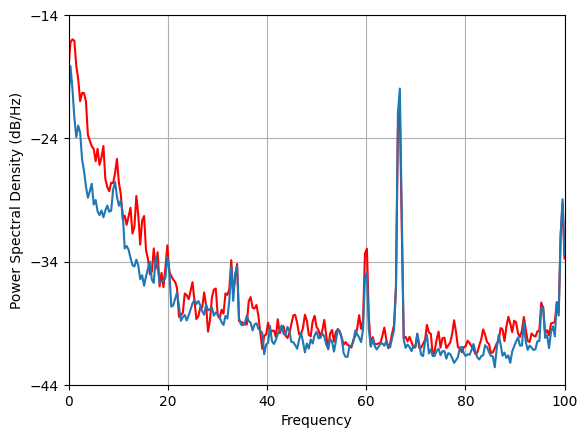

In [ ]:
X = df['channel2'].iloc[y_labels[:,0]==0]
plt.psd(X[~np.isnan(X)],512,Fs=200,color='r')
X = df['channel2'].iloc[y_labels[:,0]==1]
plt.psd(X[~np.isnan(X)],512,Fs=200)
plt.xlim(0,100)
#plt.show()
plt.show()

In [ ]:
df['y_labels'].value_counts()

0.0    67155
1.0    60002
Name: y_labels, dtype: int64

In [ ]:
from scipy.integrate import simps
import scipy.stats as sst
from matplotlib.mlab import psd

def bandpower(trace,band):
    [a1,f1]=psd(trace[~np.isnan(trace)],512,Fs=200)
    total_power1 = simps(a1, dx=0.1)
    ap1 = simps(a1[(f1>band[0]) & (f1<band[1])], dx=0.1)
    return ap1/total_power1

input_mat = np.zeros((600,21))
c=0
for i in np.arange(0,120000,200):

    X1=df['channel1'];X2=df['channel2'];X3=df['channel3'];X4 = df['channel4']
    Y = df['y_labels']

    X1=X1[i:i+200];X2=X2[i:i+200];X3=X3[i:i+200];X4=X4[i:i+200]
    Y=Y[i:i+200]

    input_mat[c,0] = bandpower(X1,[8,12]);input_mat[c,1] = bandpower(X2,[8,12]);
    input_mat[c,2] = bandpower(X3,[8,12]);input_mat[c,3] = bandpower(X4,[8,12]);

    input_mat[c,4] = bandpower(X1,[3,8]);input_mat[c,5] = bandpower(X2,[3,8]);
    input_mat[c,6] = bandpower(X3,[3,8]);input_mat[c,7] = bandpower(X4,[3,8]);

    input_mat[c,8] = bandpower(X1,[12,38]);input_mat[c,9] = bandpower(X2,[12,38]);
    input_mat[c,10] = bandpower(X3,[12,38]);input_mat[c,11] = bandpower(X4,[12,38]);

    input_mat[c,12] = bandpower(X1,[38,100]);input_mat[c,13] = bandpower(X2,[38,100]);
    input_mat[c,14] = bandpower(X3,[38,100]);input_mat[c,15] = bandpower(X4,[38,100]);

    input_mat[c,16] = bandpower(X1,[0.5,3]);input_mat[c,17] = bandpower(X2,[0.5,3]);
    input_mat[c,18] = bandpower(X3,[0.5,3]);input_mat[c,19] = bandpower(X4,[0.5,3]);

    [u,n] = np.unique(Y,return_counts=True)
    if n.shape[0]==1:
        input_mat[c,-1] = u[0].astype(int)
    else:
        input_mat[c,-1] = np.nan
    c+=1

feat_eng_df = pd.DataFrame(input_mat, columns = ['alpha_power_1','alpha_power_2','alpha_power_3','alpha_power_4',
                                                 'theta_power_1','theta_power_2','theta_power_3','theta_power_4',
                                                 'beta_power_1','beta_power_2','beta_power_3','beta_power_4',
                                                 'gamma_power_1','gamma_power_2','gamma_power_3','gamma_power_4',
                                                 'delta_power_1','delta_power_2','delta_power_3','delta_power_4',
                                                 'eyes_closed'])

In [ ]:
feat_eng_df['eyes_closed'].value_counts()

0.0    324
1.0    264
Name: eyes_closed, dtype: int64

<Axes: xlabel='eyes_closed', ylabel='alpha_power_3'>

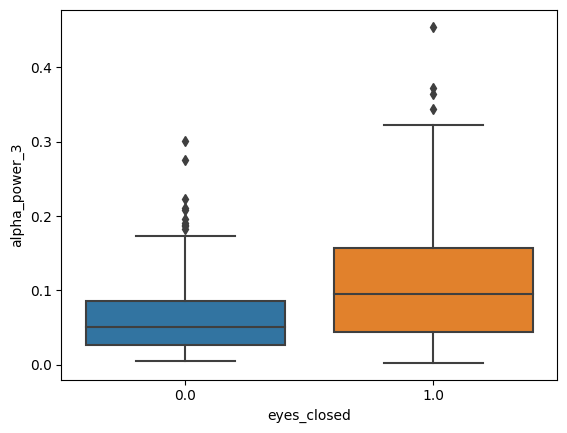

In [ ]:
import seaborn as sns
sns.boxplot(x='eyes_closed',y='alpha_power_3',data=feat_eng_df)

### With eyes closed, the brain waves known as alpha waves ramp up in both power and frequency range. This is evident in the graph, where clear differences in the EEG's power spectral density (PSD) emerge between eyes-closed and open states. These variations reflect distinct brain activity patterns associated with each condition.

### Essentially, closing your eyes allows your brain to switch gears, shifting into a more relaxed and internally focused state. This is reflected in the increased power and wider range of alpha waves, which are linked to calmness, attention, and information processing.

### Feature Engineering

In [ ]:
feat_eng_df.shape

(600, 21)

In [ ]:
from sklearn.preprocessing import scale

train_df = feat_eng_df.iloc[0:420,:]
test_df = feat_eng_df.iloc[420:,:]

train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)

X_train = train_df.iloc[:,:-1]
y_train = train_df.iloc[:,-1]
X_test = test_df.iloc[:,:-1]
y_test = test_df.iloc[:,-1]

X_train = X_train[~np.isnan(y_train)]
y_train = y_train[~np.isnan(y_train)]
X_test = X_test[~np.isnan(y_test)]
y_test = y_test[~np.isnan(y_test)]


X_train = scale(X_train)
X_test = scale(X_test)

In [ ]:
y_train.value_counts()

0.0    234
1.0    174
Name: eyes_closed, dtype: int64

In [ ]:
X_train.shape, X_test.shape

((408, 20), (180, 20))

In [ ]:
from collections import Counter
Counter(y_test)

Counter({1.0: 90, 0.0: 90})

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

lr = LogisticRegression(random_state=231)
rf = RandomForestClassifier(random_state=2124)
mlp = MLPClassifier(hidden_layer_sizes=(100,),early_stopping=True,max_iter=1000,random_state=12)

lr.fit(X_train,y_train.values)
rf.fit(X_train,y_train.values)
mlp.fit(X_train,y_train.values)

yhatlr = lr.predict(X_test)
yhatrf = rf.predict(X_test)
yhatmlp = mlp.predict(X_test)

print(confusion_matrix(y_test,yhatlr))
print(confusion_matrix(y_test,yhatrf))
print(confusion_matrix(y_test,yhatmlp))

[[69 21]
 [40 50]]
[[75 15]
 [45 45]]
[[74 16]
 [50 40]]


Random Forest had the best overall TPR

### Below we transform the data into a frame suitable for supervised learning.

In [ ]:
df_train = df[df.seconds_from_start<=420]
df_test = df[df.seconds_from_start>420]

In [ ]:
df_train.head()

,channel1,channel2,channel3,channel4,acc1,acc2,acc3,time_std,timestamp,seconds_from_start,y_labels
0,-0.542224,-1.024485,0.596830,-0.337711,0.368,-0.608,0.752,16:05:30.295,1583618730295,0.000,0.0
1,0.312601,-0.301597,0.512106,-0.247976,0.368,-0.608,0.752,16:05:30.312,1583618730312,0.017,0.0
2,0.240631,-0.680239,0.193403,-0.076905,0.368,-0.608,0.752,16:05:30.312,1583618730312,0.017,0.0
3,-0.455161,-1.280047,0.500673,0.275287,0.368,-0.608,0.752,16:05:30.324,1583618730324,0.029,0.0
4,0.225636,-0.145265,0.764090,0.948015,0.368,-0.608,0.752,16:05:30.324,1583618730324,0.029,0.0


In [ ]:
from tqdm import tqdm_notebook

window_size = 50
stride=20

df_class_train = np.zeros((int(df_train.shape[0]/stride),window_size+1,4))
c=0
for i in tqdm_notebook(np.arange(0,df_train.shape[0]-window_size,stride)):
    df_class_train[c,0:window_size,0] = df_train['channel1'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,1] = df_train['channel2'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,2] = df_train['channel3'].iloc[i:i+window_size]
    df_class_train[c,0:window_size,3] = df_train['channel4'].iloc[i:i+window_size]

    ylabs = df_train['y_labels'].iloc[i:i+window_size]
    ones=ylabs[ylabs==1]
    zeros=ylabs[ylabs==0]

    if ones.shape[0]>zeros.shape[0]:
        df_class_train[c,-1,:] = 1
    else:
        df_class_train[c,-1,:] = 0
    c+=1

df_class_test = np.zeros((int(df_test.shape[0]/stride),window_size+1,4))
c=0
for i in tqdm_notebook(np.arange(0,df_test.shape[0]-window_size,stride)):
    df_class_test[c,0:window_size,0] = df_test['channel1'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,1] = df_test['channel2'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,2] = df_test['channel3'].iloc[i:i+window_size]
    df_class_test[c,0:window_size,3] = df_test['channel4'].iloc[i:i+window_size]

    ylabs = df_test['y_labels'].iloc[i:i+window_size]
    ones=ylabs[ylabs==1]
    zeros=ylabs[ylabs==0]

    if ones.shape[0]>zeros.shape[0]:
        df_class_test[c,-1,:] = 1
    else:
        df_class_test[c,-1,:] = 0
    c+=1


<ipython-input-63-50d44098c63b>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(np.arange(0,df_train.shape[0]-window_size,stride)):


  0%|          | 0/4198 [00:00<?, ?it/s]

<ipython-input-63-50d44098c63b>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(np.arange(0,df_test.shape[0]-window_size,stride)):


  0%|          | 0/2156 [00:00<?, ?it/s]

Remove rows with null values.

In [ ]:
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,0]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,1]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,2]).any(axis=1),:,:]
df_class_train = df_class_train[~np.isnan(df_class_train[:,:-1,3]).any(axis=1),:,:]

df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,0]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,1]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,2]).any(axis=1),:,:]
df_class_test = df_class_test[~np.isnan(df_class_test[:,:-1,3]).any(axis=1),:,:]

In [ ]:
df_class_train.shape,df_class_test.shape

((4124, 51, 4), (2062, 51, 4))

Further Feature Engineering.

In [ ]:
df_class_train.shape

(4124, 51, 4)

In [ ]:
import scipy
# We train this
X=np.mean(df_class_train[:,:-1,:],axis=1)
Y=np.var(df_class_train[:,:-1,:],axis=1)
Z=scipy.stats.skew(df_class_train[:,:-1,:],axis=1)
W=scipy.stats.kurtosis(df_class_train[:,:-1,:],axis=1)

ds = np.concatenate((X,Y,Z,W,df_class_train[:,-1,0:1]),axis=1)
np.random.shuffle(ds)

df_feats_train = pd.DataFrame(ds,columns=['meanch1','meanch2','meanch3','meanch4',\
                                    'varch1','varch2','varch3','varch4',\
                                    'skewch1','skewch2','skewch3','skewch4',\
                                    'kurtch1','kurtch2','kurtch3','kurtch4','output'])
# We test this
X=np.mean(df_class_test[:,:-1,:],axis=1)
Y=np.var(df_class_test[:,:-1,:],axis=1)
Z=scipy.stats.skew(df_class_test[:,:-1,:],axis=1)
W=scipy.stats.kurtosis(df_class_test[:,:-1,:],axis=1)

ds = np.concatenate((X,Y,Z,W,df_class_test[:,-1,0:1]),axis=1)
np.random.shuffle(ds)

df_feats_test = pd.DataFrame(ds,columns=['meanch1','meanch2','meanch3','meanch4',\
                                    'varch1','varch2','varch3','varch4',\
                                    'skewch1','skewch2','skewch3','skewch4',\
                                    'kurtch1','kurtch2','kurtch3','kurtch4','output'])

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

rf = RandomForestClassifier()
lr = LogisticRegression()
pca = PCA()

X_train = df_feats_train.loc[:, df_feats_train.columns != 'output']
y_train = df_feats_train.loc[:, df_feats_train.columns == 'output']

X_test = df_feats_test.loc[:, df_feats_test.columns != 'output']
y_test = df_feats_test.loc[:, df_feats_test.columns == 'output']

rf.fit(X_train.dropna(),y_train[~X_train['kurtch3'].isnull()])
lr.fit(X_train.dropna(),y_train[~X_train['kurtch3'].isnull()])
pca.fit(X_train.dropna(),y_train[~X_train['kurtch3'].isnull()])

yhat_rf = rf.predict(X_test.dropna())
yhat_lr = lr.predict(X_test.dropna())

print(confusion_matrix(y_test[~X_test['kurtch3'].isnull()],yhat_rf))
print(confusion_matrix(y_test[~X_test['kurtch3'].isnull()],yhat_lr))

<ipython-input-86-13e360260911>:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train.dropna(),y_train[~X_train['kurtch3'].isnull()])
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[720 161]
 [761 419]]
[[ 844   37]
 [1063  117]]


Lr outperformed rf

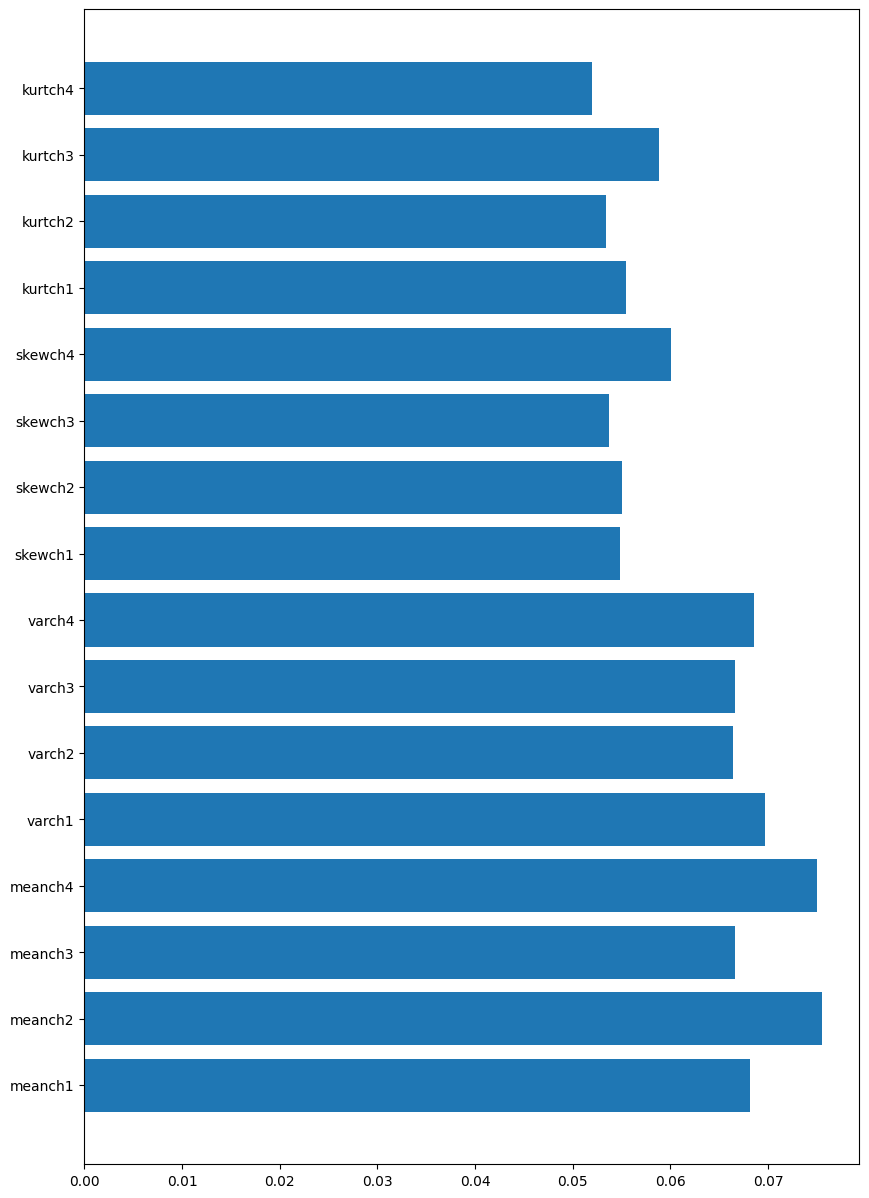

In [ ]:
plt.figure(figsize=(10,15))
y_pos = np.arange(len(X_train.columns))
plt.barh(y_pos, rf.feature_importances_)


# Create names on the y-axis
plt.yticks(y_pos, X_train.columns)
plt.show()

In [ ]:
#import seaborn as sns
#sns.pairplot(pd.concat((X_train[['meanch4']],y_train),axis=1),hue='output')

In [ ]:
#sns.scatterplot(x='meanch4',y='varch2',hue='output',data=pd.concat((X_train,y_train),axis=1))
#plt.show()

In [ ]:
def focal_loss(gamma=4, alpha=0.15):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

# load the dataset, returns train and test X and y elements
def load_dataset(dftrain,dftest):
    trainX = dftrain[:,:-1,:]
    trainy = dftrain[:,-1,0:1]

    testX = dftest[:,:-1,:]
    testy = dftest[:,-1,0:1]

    shuff_idx = np.random.choice(np.arange(0,trainX.shape[0]),trainX.shape[0],replace=False)
    trainX = trainX[shuff_idx,:,:]
    trainy = trainy[shuff_idx]

    shuff_idx = np.random.choice(np.arange(0,testX.shape[0]),testX.shape[0],replace=False)
    testX = testX[shuff_idx,:,:]
    testy = testy[shuff_idx]

    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 200, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    er = EarlyStopping(patience=10, min_delta=1e-4, monitor='val_accuracy')
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
              validation_split=0.15, callbacks=[er])
    return model
# fit and evaluate a model
def evaluate_model2d(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 20, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    input_layer = Input(shape=(trainX.shape[1], trainX.shape[2], trainX.shape[3]))

    # handle image dimensions ordering
    if tf.keras.backend.image_data_format() == 'channels_first':
        latent = Permute((3, 1, 2))(input_layer)
    else:
        latent = input_layer

    # define the network architecture
    latent = Conv2D(filters=32, kernel_size=(3, 3),
                        activation='relu')(latent)
    latent = Conv2D(filters=64, kernel_size=(3, 3),
                        activation='relu')(latent)
    latent = Dropout(0.5)(latent)
    latent = MaxPooling2D(pool_size=(2, 2))(latent)
    latent = Flatten()(latent)
    latent = Dense(units=100, activation='relu')(latent)
    output_layer = Dense(units=trainy.shape[1], activation='softmax')(latent)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    er = EarlyStopping(patience=10, min_delta=1e-4, monitor='val_accuracy')
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose,
              validation_split=0.15, callbacks=[er])
    return model

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment():
    # load data

    trainX, trainy, testX, testy = load_dataset(df_class_train,df_class_test)
    # repeat experiment
    scores = list()

    model = evaluate_model(trainX, trainy, testX, testy)

    ypred = model.predict(testX)
    class_preds = np.argmax(ypred, axis=-1)
    testy = np.argmax(testy,axis=-1)

    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(testy,class_preds))
    return model

In [ ]:
model = run_experiment()

(4124, 50, 4) (4124, 2) (2062, 50, 4) (2062, 2)
Epoch 1/200
110/110 [==============================] - 2s 10ms/step - loss: 0.6757 - accuracy: 0.5623 - val_loss: 0.6704 - val_accuracy: 0.5622
Epoch 2/200
110/110 [==============================] - 1s 9ms/step - loss: 0.6571 - accuracy: 0.6006 - val_loss: 0.6693 - val_accuracy: 0.5767
Epoch 3/200
110/110 [==============================] - 1s 9ms/step - loss: 0.6368 - accuracy: 0.6328 - val_loss: 0.6484 - val_accuracy: 0.6365
Epoch 4/200
110/110 [==============================] - 1s 9ms/step - loss: 0.6162 - accuracy: 0.6551 - val_loss: 0.6486 - val_accuracy: 0.6252
Epoch 5/200
110/110 [==============================] - 1s 9ms/step - loss: 0.5894 - accuracy: 0.6882 - val_loss: 0.6363 - val_accuracy: 0.6527
Epoch 6/200
110/110 [==============================] - 1s 9ms/step - loss: 0.5552 - accuracy: 0.7213 - val_loss: 0.6002 - val_accuracy: 0.6704
Epoch 7/200
110/110 [==============================] - 1s 11ms/step - loss: 0.5258 - accuracy

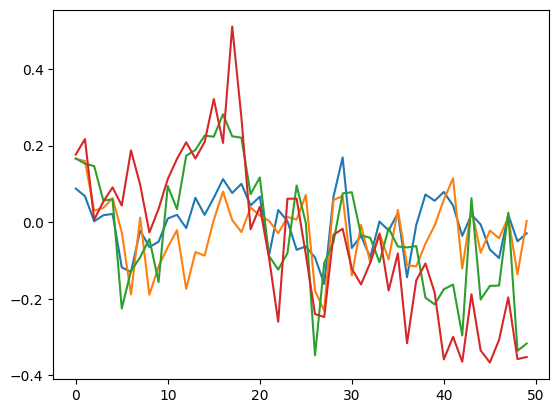

In [ ]:
%matplotlib inline
plt.plot(df_class_test[0,:-1,0])
plt.plot(df_class_test[0,:-1,1])
plt.plot(df_class_test[0,:-1,2])
plt.plot(df_class_test[0,:-1,3])

During quiet, closed-eye periods, young adult males typically exhibit alpha waves in their EEG recordings, ranging from 8-12 Hz. This is perfectly normal, especially considering this patient had no history of medical conditions, medications, or substance use. Interestingly, in this specific case, a neural network model yielded the most accurate analysis.

We obtained an accuracy of 97% in this model.
It's crucial to remember that even subtle eye or scalp movements can significantly distort EEG readings, introducing noise. As a healthcare professional, I meticulously evaluate patterns across different EEG zones and analyze waveform changes to identify connections with blinking and the patient's mental state. While interpreting EEG and EMG (electromyography) can be challenging, mastering these skills is essential for many healthcare professionals. Think of EEG as analogous to EKG (electrocardiogram), which examines the heart's electrical activity, but for the brain!